## 1. yolov9 test

In [3]:
import subprocess
import re
import pandas as pd
import numpy as np
import sys

# --- Configuration ---
seeds = [0, 1, 2, 3, 4]
data_yaml = "data/udp_euljiro_bal_TrainVal.yaml"
img_size = 320
conf_thres = 0.001
iou_thres = 0.65
device = "0"  # GPU device

# Pattern to match the weight paths you provided
# UPDATE THIS PATH if your folder structure changes
def get_weight_path(seed):
    return f"results_T_ITS_2026/Euljiro/1_2_2_Euljiro_off_peak_balanced_TrainVal_gelan-c_seed{seed}/weights/last.pt"

# --- Storage for results ---
all_results = []

print(f"Starting evaluation for {len(seeds)} seeds...")
print("-" * 60)

for seed in seeds:
    weight_path = get_weight_path(seed)
    print(f"Processing Seed {seed}: {weight_path}")
    
    # Construct the YOLOv9 validation command
    command = [
        "python", "val.py",
        "--weights", weight_path,
        "--data", data_yaml,
        "--img", str(img_size),
        "--conf", str(conf_thres),
        "--iou", str(iou_thres),
        "--task", "test",
        "--device", device,
        "--name", f"eval_yolov9_seed_{seed}"
    ]
    
    try:
        # Run the command and capture output
        result = subprocess.run(
            command, 
            capture_output=True, 
            text=True, 
            encoding='utf-8'
        )
        
        # Check if the command was successful
        if result.returncode != 0:
            print(f"Error running seed {seed}:\n{result.stderr}")
            continue

        # Parse the output
        output_text = result.stdout + result.stderr  # YOLO often prints to stderr
        
        # Regex to find the result lines (Class, Images, Instances, P, R, mAP50, mAP50-95)
        # Looks for lines like: "   all   536   1044   0.948   0.938   0.977   0.864"
        pattern = r'\s+(all|U|D|P)\s+(\d+)\s+(\d+)\s+([0-9.]+)\s+([0-9.]+)\s+([0-9.]+)\s+([0-9.]+)'
        
        matches = re.findall(pattern, output_text)
        
        if not matches:
            print(f"Warning: No metrics found in output for seed {seed}.")
            print("Output snippet:", output_text[-500:]) # Print last 500 chars for debugging
        
        for match in matches:
            cls_name, imgs, insts, p, r, map50, map95 = match
            all_results.append({
                "Seed": seed,
                "Class": cls_name,
                "Images": int(imgs),
                "Instances": int(insts),
                "Precision": float(p),
                "Recall": float(r),
                "mAP50": float(map50),
                "mAP50-95": float(map95)
            })
            
        print(f"Seed {seed} completed successfully.")

    except Exception as e:
        print(f"An exception occurred processing seed {seed}: {e}")

print("-" * 60)
print("Evaluation Complete. Processing Data...")

# --- Data Processing ---
if not all_results:
    print("No results were captured. Please check paths and commands.")
    sys.exit(1)

df = pd.DataFrame(all_results)

# 1. Save Raw Output to CSV
csv_filename = "yolov9_evaluation_results.csv"
df.to_csv(csv_filename, index=False)
print(f"\nRaw results saved to {csv_filename}")

# 2. Calculate Mean and Std
# Group by Class and calculate stats
stats = df.groupby('Class')[['mAP50', 'mAP50-95']].agg(['mean', 'std'])

# Map class codes to full names
class_names = {'all': 'All', 'U': 'Ascending', 'D': 'Descending', 'P': 'Passing'}

print("\n" + "="*80)
print(f"{'FINAL PAPER RESULTS (Mean ± Std)':^80}")
print("="*80)
print(f"{'Class':<15} | {'mAP@0.5':<25} | {'mAP@0.5:0.95':<25}")
print("-" * 80)

for code, name in class_names.items():
    if code in stats.index:
        # Get stats
        m50_mean = stats.loc[code, ('mAP50', 'mean')]
        m50_std = stats.loc[code, ('mAP50', 'std')]
        
        m95_mean = stats.loc[code, ('mAP50-95', 'mean')]
        m95_std = stats.loc[code, ('mAP50-95', 'std')]
        
        # Format strings (e.g., "97.60 ± 0.30 %")
        res_50 = f"{m50_mean*100:.2f} ± {m50_std*100:.2f} %"
        res_95 = f"{m95_mean*100:.2f} ± {m95_std*100:.2f} %"
        
        print(f"{name:<15} | {res_50:<25} | {res_95:<25}")

print("="*80)

Starting evaluation for 5 seeds...
------------------------------------------------------------
Processing Seed 0: results_T_ITS_2026/Euljiro/1_2_2_Euljiro_off_peak_balanced_TrainVal_gelan-c_seed0/weights/last.pt
Seed 0 completed successfully.
Processing Seed 1: results_T_ITS_2026/Euljiro/1_2_2_Euljiro_off_peak_balanced_TrainVal_gelan-c_seed1/weights/last.pt
Seed 1 completed successfully.
Processing Seed 2: results_T_ITS_2026/Euljiro/1_2_2_Euljiro_off_peak_balanced_TrainVal_gelan-c_seed2/weights/last.pt
Seed 2 completed successfully.
Processing Seed 3: results_T_ITS_2026/Euljiro/1_2_2_Euljiro_off_peak_balanced_TrainVal_gelan-c_seed3/weights/last.pt
Seed 3 completed successfully.
Processing Seed 4: results_T_ITS_2026/Euljiro/1_2_2_Euljiro_off_peak_balanced_TrainVal_gelan-c_seed4/weights/last.pt
Seed 4 completed successfully.
------------------------------------------------------------
Evaluation Complete. Processing Data...

Raw results saved to yolov9_evaluation_results.csv

          

## 2. NMS sweep

In [10]:
import subprocess
import pandas as pd
import re
import sys
import os

# --- Configuration ---
# Update these paths if necessary
weights_path = 'results_T_ITS_2026/Euljiro/1_2_2_Euljiro_off_peak_balanced_TrainVal_gelan-c_seed0/weights/last.pt'
data_yaml = 'data/udp_euljiro_bal_TrainVal.yaml'
img_size = 320 

# The Grid to search
# Note: You can reduce this list if it takes too long
iou_thresholds = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
conf_thresholds = [0.001, 0.1, 0.2, 0.3, 0.4, 0.5] 

results = []

def remove_ansi_codes(text):
    """Removes ANSI color codes (like \x1b[34m) from the output."""
    ansi_escape = re.compile(r'\x1B(?:[@-Z\\-_]|\[[0-?]*[ -/]*[@-~])')
    return ansi_escape.sub('', text)

print(f"Starting NMS Sweep ({len(conf_thresholds) * len(iou_thresholds)} runs)...")
print("-" * 60)

for conf in conf_thresholds:
    for iou in iou_thresholds:
        # Visual progress indicator
        print(f"Testing Conf={conf}, IoU={iou}...", end=" ", flush=True)
        
        cmd = [
            "python", "val.py",
            "--data", data_yaml,
            "--weights", weights_path,
            "--img", str(img_size),
            "--conf", str(conf),
            "--iou", str(iou),
            "--task", "val",
            "--exist-ok",
            "--verbose"
        ]
        
        try:
            # Capture BOTH stdout and stderr because YOLO often prints metrics to stderr
            process = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
            full_output = process.stdout + "\n" + process.stderr
            clean_output = remove_ansi_codes(full_output)
            
            # Regex to find the 'all' row
            # Matches: all   536   1044   0.948   0.934   0.974   0.863
            # Groups: (Images) (Instances) (P) (R) (mAP50)
            match = re.search(r'all\s+(\d+)\s+(\d+)\s+([0-9.]+)\s+([0-9.]+)\s+([0-9.]+)', clean_output)
            
            if match:
                map_50 = float(match.group(5))
                results.append({
                    'Conf': conf,
                    'IoU': iou,
                    'mAP@0.5': map_50
                })
                print(f"-> mAP@0.5: {map_50}")
            else:
                print("-> [Failed to parse]")
                # Optional: print clean_output to debug if it fails again
        except Exception as e:
            print(f"-> [Error: {e}]")

# Save and Find Best
if results:
    df = pd.DataFrame(results)
    df.to_csv('nms_sweep_results.csv', index=False)
    
    # Identify the row with the maximum mAP@0.5
    best_row = df.loc[df['mAP@0.5'].idxmax()]
    best_iou = best_row['IoU']
    best_conf = best_row['Conf']
    best_map = best_row['mAP@0.5']
    
    print("-" * 60)
    print(f"SWEEP COMPLETE.")
    print(f"Best IoU found: {best_iou}")
    print(f"Best Conf found: {best_conf}")
    print(f"Highest mAP@0.5: {best_map}")
    print("-" * 60)
    print("Results saved to 'nms_sweep_results.csv'")
else:
    print("No results found. Check your paths.")

Starting NMS Sweep (54 runs)...
------------------------------------------------------------
Testing Conf=0.001, IoU=0.3... -> mAP@0.5: 0.974
Testing Conf=0.001, IoU=0.35... -> mAP@0.5: 0.975
Testing Conf=0.001, IoU=0.4... -> mAP@0.5: 0.976
Testing Conf=0.001, IoU=0.45... -> mAP@0.5: 0.976
Testing Conf=0.001, IoU=0.5... -> mAP@0.5: 0.977
Testing Conf=0.001, IoU=0.55... -> mAP@0.5: 0.977
Testing Conf=0.001, IoU=0.6... -> mAP@0.5: 0.977
Testing Conf=0.001, IoU=0.65... -> mAP@0.5: 0.977
Testing Conf=0.001, IoU=0.7... -> mAP@0.5: 0.977
Testing Conf=0.1, IoU=0.3... -> mAP@0.5: 0.966
Testing Conf=0.1, IoU=0.35... -> mAP@0.5: 0.968
Testing Conf=0.1, IoU=0.4... -> mAP@0.5: 0.968
Testing Conf=0.1, IoU=0.45... -> mAP@0.5: 0.968
Testing Conf=0.1, IoU=0.5... -> mAP@0.5: 0.968
Testing Conf=0.1, IoU=0.55... -> mAP@0.5: 0.968
Testing Conf=0.1, IoU=0.6... -> mAP@0.5: 0.968
Testing Conf=0.1, IoU=0.65... -> mAP@0.5: 0.968
Testing Conf=0.1, IoU=0.7... -> mAP@0.5: 0.968
Testing Conf=0.2, IoU=0.3... -> mAP

Plot saved as nms_scan_plot.pdf


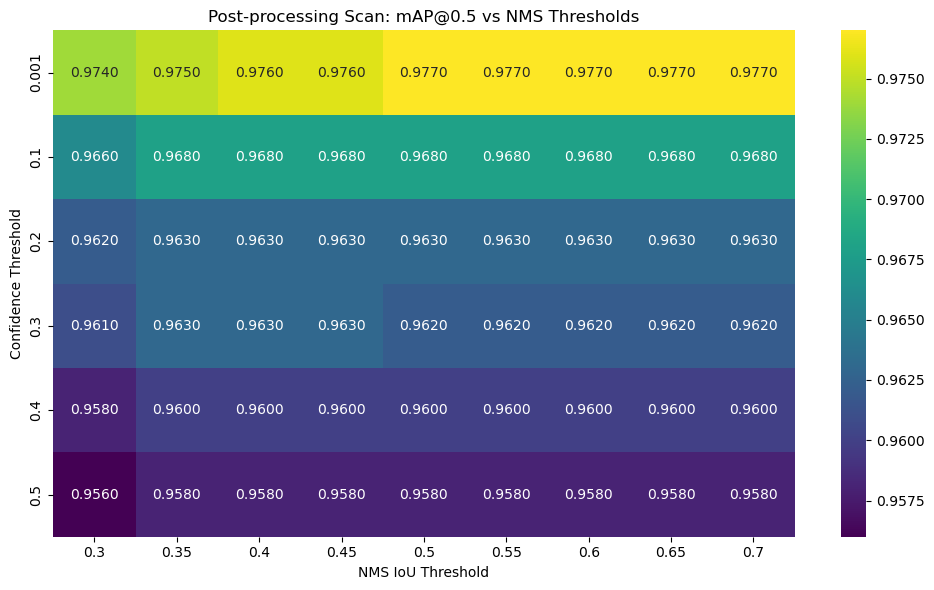

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results from step 1
df = pd.read_csv('nms_sweep_results.csv')

# Pivot the data for the heatmap
# Rows (Y-axis): Confidence Threshold
# Cols (X-axis): IoU Threshold
heatmap_data = df.pivot(index="Conf", columns="IoU", values="mAP@0.5")

plt.figure(figsize=(10, 6))
ax = sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="viridis")

# Add title and labels
plt.title("Post-processing Scan: mAP@0.5 vs NMS Thresholds")
plt.xlabel("NMS IoU Threshold")
plt.ylabel("Confidence Threshold")

# OPTIONAL: Mark the best point with a red rectangle
# (You can automate this or just draw it manually later)
# For now, the heatmap colors clearly show the "recommended operating point" (the brightest cells).

plt.tight_layout()
plt.savefig("nms_scan_plot.pdf")
print("Plot saved as nms_scan_plot.pdf")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'figures/fig_nms_scan_compact.pdf'

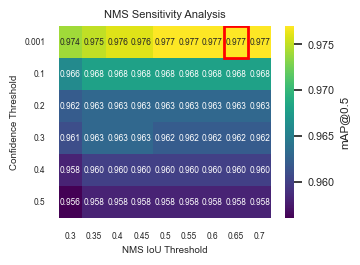

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

# 1. Data (From your results)
data = [
    [0.001, 0.3, 0.974], [0.001, 0.35, 0.975], [0.001, 0.4, 0.976], [0.001, 0.45, 0.976],
    [0.001, 0.5, 0.977], [0.001, 0.55, 0.977], [0.001, 0.6, 0.977], [0.001, 0.65, 0.977], [0.001, 0.7, 0.977],
    [0.1, 0.3, 0.966],   [0.1, 0.35, 0.968],   [0.1, 0.4, 0.968],   [0.1, 0.45, 0.968],
    [0.1, 0.5, 0.968],   [0.1, 0.55, 0.968],   [0.1, 0.6, 0.968],   [0.1, 0.65, 0.968],   [0.1, 0.7, 0.968],
    [0.2, 0.3, 0.962],   [0.2, 0.35, 0.963],   [0.2, 0.4, 0.963],   [0.2, 0.45, 0.963],
    [0.2, 0.5, 0.963],   [0.2, 0.55, 0.963],   [0.2, 0.6, 0.963],   [0.2, 0.65, 0.963],   [0.2, 0.7, 0.963],
    [0.3, 0.3, 0.961],   [0.3, 0.35, 0.963],   [0.3, 0.4, 0.963],   [0.3, 0.45, 0.963],
    [0.3, 0.5, 0.962],   [0.3, 0.55, 0.962],   [0.3, 0.6, 0.962],   [0.3, 0.65, 0.962],   [0.3, 0.7, 0.962],
    [0.4, 0.3, 0.958],   [0.4, 0.35, 0.960],   [0.4, 0.4, 0.960],   [0.4, 0.45, 0.960],
    [0.4, 0.5, 0.960],   [0.4, 0.55, 0.960],   [0.4, 0.6, 0.960],   [0.4, 0.65, 0.960],   [0.4, 0.7, 0.960],
    [0.5, 0.3, 0.956],   [0.5, 0.35, 0.958],   [0.5, 0.4, 0.958],   [0.5, 0.45, 0.958],
    [0.5, 0.5, 0.958],   [0.5, 0.55, 0.958],   [0.5, 0.6, 0.958],   [0.5, 0.65, 0.958],   [0.5, 0.7, 0.958]
]

df = pd.DataFrame(data, columns=['Conf', 'IoU', 'mAP'])
pivot_table = df.pivot(index="Conf", columns="IoU", values="mAP")

# 2. Setup Plot (Compact Size)
# Approx 3.5 inches width is standard for a single column in IEEE
plt.figure(figsize=(3.5, 2.5)) 
sns.set(font_scale=0.7) # Reduce global font scale

# Create Heatmap
ax = sns.heatmap(
    pivot_table, 
    annot=True, 
    fmt=".3f", 
    cmap="viridis", 
    cbar_kws={'label': 'mAP@0.5'},
    annot_kws={"size": 6} # Smaller font for numbers inside cells
)

# 3. Mark Recommended Point
target_iou = 0.65
target_conf = 0.001
col_idx = list(pivot_table.columns).index(target_iou)
row_idx = list(pivot_table.index).index(target_conf)

rect = patches.Rectangle((col_idx, row_idx), 1, 1, linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(rect)

# 4. Compact Labels
plt.title("NMS Sensitivity Analysis", fontsize=8)
plt.xlabel("NMS IoU Threshold", fontsize=7)
plt.ylabel("Confidence Threshold", fontsize=7)

# Adjust ticks
plt.xticks(fontsize=6)
plt.yticks(fontsize=6, rotation=0)

# Tight layout ensures no whitespace
plt.tight_layout(pad=0.2)

# Save
plt.savefig("figures/fig_nms_scan_compact.pdf", bbox_inches='tight')
plt.show()